#<b>Multivariate analyses for untargeted metabolomics data, focus on PCoA and PERMANOVA </b> <br>
Authors: M Ernst, F Russo<br>
Last update: July 28, 2022<br>

In this notebook we will perform a Principal Coordinate Analysis (PCoA), also known as metric or classical Multidimensional Scaling (metric MDS) to explore and visualize patterns in an untargeted mass spectromtery-based metabolomics dataset. We will then assess statistical significance of the patterns and dispersion of different sample types using permutational multivariate analysis of variance (PERMANOVA). <br>

<b>Data</b> <br>
The files used in this tutorial are a subset of an untargeted LC-MS/MS metabolomics dataset of bacterial cultures to which pooled antibiotics were added (sulfomethoxazole, sulfadimethoxine, cyproconazole and asulam) to investigate potential biotransformations. [needs to be replaced] Data were acquired on a Dionex UltiMate 3000 Thermo Fisher Scientific HPLC system coupled to a Bruker Impact HD quadrupole time of flight (qTOF) mass spectrometer. MS/MS data were acquired in data dependent acquisition (DDA) with fragmentation of the seven most abundant ions in the spectrum [needs to be replaced]. Data files were subsequently preprocessed using MZmine2 and the feature-based molecular networking workflow in GNPS.

<b>Questions</b><br>
- Is there a difference in the metabolomic profiles of different bacterial species?<br>
- Is there a difference in the metabolomic profiles of different sample types?<br>
- Is there a difference in the bacterial metabolomic profiles across different timepoints?<br>

Install and load libraries

In [1]:
install.packages('vegan')
install.packages('ggplot2')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘permute’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(vegan)
library(ggplot2)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2



In [48]:
# last update
Sys.time()

[1] "2022-07-28 15:02:50 UTC"

Specify where the data can be found by providing urls for the featuretable and metadata

In [3]:
# Here, we import the files from GitHub but you can import them from your local computer or from Google Drive as well of course
# cleaned and imputed (but not normalized feature table)
ft_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Summer-School_Functional-Metabolomics/main/MZmine%20Files_Results_Generated_using_JupyterNotebook/Imputed_QuantTable_with_MinValue_3766_Full.csv'
# metadata
md_url <- 'https://raw.githubusercontent.com/Functional-Metabolomics-Lab/Summer-School_Functional-Metabolomics/main/MZmine%20Files/20220726_Xenobiotic_Metabolism_metadata.txt'

In [4]:
ft <- read.csv(ft_url, header = T, check.names = F, row.names = 1)
md <- read.csv(md_url, header = T, check.names = F, sep = '\t')

In [5]:
dim(ft)
dim(md)

[1] 5759   80

[1] 82  7

In [13]:
head(ft, n=2)

,48_284.049_0.296,97_245.095_0.521,105_181.097_0.521,108_157.097_0.52,113_166.103_0.533,114_160.076_0.522,120_169.097_0.525,128_318.184_0.528,132_166.086_0.53,134_228.121_0.534,⋯,12354_387.733_8.206,12355_214.918_8.214,12356_230.89_8.216,12357_248.9_8.216,12361_304.894_8.146,12386_245.128_8.986,12440_161.082_9.725,12447_179.093_9.788,12450_261.123_9.888,12453_261.123_9.91
t2_Ec_C.mzML,57190.83,3766,3766,3766,3766,3766,3766,3766,3766,3766,⋯,3766,27512.27,96410.06,44757.77,38627.54,62094.82,606578.4,608501.2,86233.76,35417.67
t2_BS_C.mzML,30703.12,3766,3766,3766,3766,3766,3766,3766,3766,3766,⋯,3766,24718.62,96060.30,45181.07,47485.14,50183.21,601207.0,606486.2,74582.01,63652.69


In [14]:
head(md, n=2)

,filename,ATTRIBUTE_species,ATTRIBUTE_SampleType,ATTRIBUTE_timepoint,ATTRIBUTE_hours,ATTRIBUTE_mins,ATTRIBUTE_replicates
,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<fct>
t0_BS_1.mzML,t0_BS_1.mzML,B.subtilis,With_Treatment,0,-0.1666667,-10,1
t0_BS_2.mzML,t0_BS_2.mzML,B.subtilis,With_Treatment,0,-0.1666667,-10,2


<b>Bring featuretable and metadata in the correct format:</b><br>

Get rid of 'Peak area' extension in filenames to match with metadata and transform metadata rownames to filenames, transform featuretable rownames to a unique identifier consisting of feature IDs, m/z and RT
Remove NA columns from metadata

In [6]:
# clean column names of feature table and metadata
# colnames(ft) <- gsub(' Peak area','',colnames(ft))
md$filename <- gsub(' Peak area','',md$filename)
# keep only columns in metadata without NAs
md <- md[,1:7]
rownames(md) <- md$filename
# create an identifier based on row ID, m/z and RT for each feature
# rownames(ft) <- paste(ft$'row ID',round(ft$'row m/z',digits = 3),round(ft$'row retention time',digits = 3), sep = '_')
# ft <- ft[,grep('mzML',colnames(ft))]
md$ATTRIBUTE_replicates <- as.factor(md$ATTRIBUTE_replicates)

In [7]:
table(rownames(md) %in% colnames(ft))


FALSE  TRUE 
    2    80 

In [8]:
# the blanks are the only files not present in ft
setdiff(rownames(md),colnames(ft))

[1] "Blank_A.mzML" "Blank_B.mzML"

In [9]:
# filter out the blank samples from md
md <- md[rownames(md) %in% colnames(ft),]

In [10]:
dim(md)

[1] 80  7

In [11]:
# transpose ft
ft <- t(ft)

In [12]:
dim(ft)

[1]   80 5759

<b>Principal coordinates analysis (PCoA)</b><br>

Principal coordinates analysis (PCoA) is a metric multidimensional scaling (MDS) method that attempts to represent sample dissimilarities in a low-dimensional space. It converts a distance matrix consisting of pair-wise distances (dissimilarities) across samples into a 2- or 3-D graph (Gower, 2005). Different distance metrics can be used to calculate dissimilarities among samples (e.g. Euclidean, Canberra, Minkowski). Performing a principal coordinates analysis using the Euclidean distance metric is the same as performing a principal components analysis (PCA). Selecting the best distance metric for a given dataset is part of the 'art' of data science.<br>

Within the metabolomics field the Euclidean, Bray-Curtis, Jaccard or Canberra distances are most commonly used. The Jaccard distance is an unweighted metric (presence/absence) whereas Euclidean, Bray-Curtis and Canberra distances take into account relative abundances (weighted).<br>

This video tutorial by StatQuest summarizes nicely the basic principles of PCoA: https://www.youtube.com/watch?v=GEn-_dAyYME<br>

In order to perform a PCoA as described below, it is important that the filenames in our metadata are identical as well as in the same order as the filenames in our featuretable. Let's make sure this is true, using the below code (this should return TRUE).

In [15]:
identical(rownames(ft),rownames(md))
# make the rows in ft and md in the same order
ft <- ft[match(rownames(md),rownames(ft)),]
identical(rownames(ft),rownames(md))

[1] FALSE

[1] TRUE

Now, let's scale and center the data.

In [23]:
ft <- scale(ft, scale = TRUE, center = TRUE)

Next, we will calculate pairwise distances across all samples using the Canberra distance metric.

In [24]:
distm <- dist(ft, method = 'canberra')

All pairwise Canberra distances are now stored within our distance (dissimilarity) matrix (distm). The distance matrix is then used as input for the PCoA. At first, we here color samples according to the bacterial species (ATTRIBUTE_species within our metadata)



In [32]:
PcoA <- cmdscale(distm, k =2)
PcoA <- as.data.frame(PcoA)
names(PcoA)[1:2] <- c('PCoA1', 'PCoA2')

In [33]:
head(PcoA)

,PCoA1,PCoA2
,<dbl>,<dbl>
t0_BS_1.mzML,1238.2548,1395.0599
t0_BS_2.mzML,1174.2181,1337.1801
t0_BS_3.mzML,1326.1737,1340.3355
t0_BS_C.mzML,-161.9399,856.5407
t0_Ec_1.mzML,376.9509,-309.6897
t0_Ec_2.mzML,275.5966,-316.7835


In [34]:
identical(rownames(PcoA), rownames(md))

[1] TRUE

Using the [ggplot2](https://cran.r-project.org/web/packages/ggplot2/index.html) library, we can plot our PCoA.

In [35]:
table(md$ATTRIBUTE_species)


B.subtilis     E.coli 
        40         40 

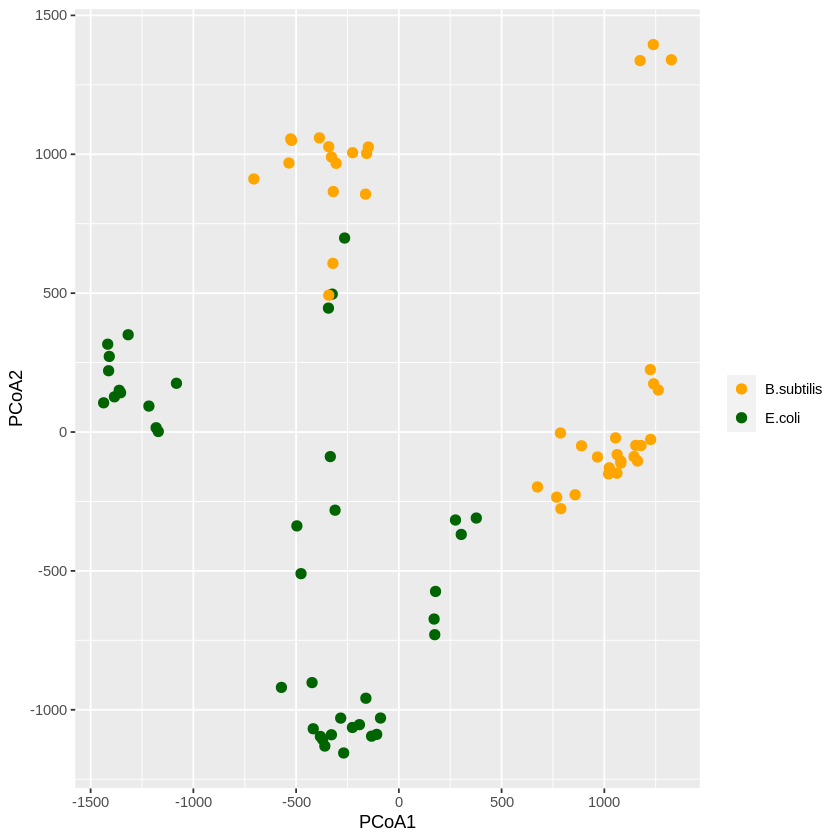

In [37]:
ggplot(PcoA, aes(x = PCoA1, y = PCoA2, colour = md$ATTRIBUTE_species, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_manual(values = c('orange','darkgreen')) +
            theme(legend.title=element_blank())

It looks like there is a strong separation between samples of E.coli and B. subtilis. But is the separation significant? Let's perform a permutational multivariate analysis of variance (PERMANOVA) to find out!

<b>Permutational multivariate analysis of variance (PERMANOVA)</b><br>

Permutational multivariate analysis of variance (PERMANOVA) is a non-parametric method for multivariate analysis of variance, where P-values are obtained using permutations. The metric was originally developed within the field of ecology (Anderson, 2008) but is today widely used in other fields, including the microbiome and metabolomics field. PERMANOVA is used to compare groups of samples and tests whether the centroid and/or the spread of the samples is different between the groups.<br>

The adonis2() function in the vegan package can be used to perform a PERMANOVA. The input is any dissimilarity matrix and the test-statistic retrieved is a multivariate analogue to Fisher's F-ratio as well as an R2 value (Adonis R2).

In [43]:
adonres <- adonis2(distm ~ md[,colnames(md) == 'ATTRIBUTE_species'])

In [44]:
adonres

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"md[, colnames(md) == ""ATTRIBUTE_species""]",1,40309832,0.1630335,15.19369,0.001
Residual,78,206938932,0.8369665,NA,NA
Total,79,247248763,1.0000000,NA,NA


The PERMANOVA test result tells us that there is a significant difference in the metabolomic profiles of E.coli and B.subtilis (PERMANOVA, P < 0.05, Adonis R2 = 0.1630) and that app. 16% of the variation in our data can be explained by bacterial species.

<b>Perform PCoA and assess separation using PERMANOVA</b><br>

To speed up the analysis and so we don't have to explore all metadata categories one by one, we can define a function, which will perform a principal coordinates analysis (PCoA) using a distance metric of choice, calculate a PERMANOVA and plot results in a 2-D graph:

In [59]:
plotPCoA <- function(ft, md, distmetric = c("euclidean", "maximum", "manhattan", "canberra", "binary", 
                                                  "minkowski"), collow = "#810f7c", colhigh ="#f7fcb9", 
                      catper = "plate", catcols = "plate", mdtype = 'categorical', 
                      cols = c('grey','black','orange','pink','darkgreen','darkred','brown','blue','skyblue3','green'),
                      title = 'Principal coordinates plot'){
    
    catper <<- catper
    distm <- dist(ft, method = distmetric)
    d <- as.matrix(distm)

    if (length(which(is.na(md[,colnames(md) == catper]))) !=0){
          red <- as.dist(as.matrix(distm)[-which(is.na(md[,colnames(md) == catper])),-which(is.na(md[,colnames(md) == catper]))])
          adonres <- adonis2(red ~ na.omit(md[,colnames(md) == catper]))
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        } else {
          adonres <- adonis2(distm ~ md[,colnames(md) == catper])
          Rsq <- adonres$R2[1]
          pval <- adonres$'Pr(>F)'[1]
        }

    PcoA <- cmdscale(distm, k =2)
    PcoA <- as.data.frame(PcoA)
    PcoA$Group <- md[,colnames(md) == catcols][match(rownames(PcoA),rownames(md))]
    names(PcoA)[1:2] <- c('PCoA1', 'PCoA2')
    
    # plot
    cbPalette <- cols

    if (mdtype == 'continuous'){
          Tr_PcoA <- ggplot(PcoA, aes(x = PCoA1, y = PCoA2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_gradient(low = collow, high = colhigh,space = "Lab", na.value = "grey50", guide = "colourbar",aesthetics = "colour")+
            theme(legend.title=element_blank()) +
            ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" "))

        } else {

          Tr_PcoA <- ggplot(PcoA, aes(x = PCoA1, y = PCoA2, colour = Group, label = row.names(PcoA))) + geom_point(size=2.5) +
            scale_colour_manual(values = cbPalette) +
            theme(legend.title=element_blank()) +
            ggtitle(paste(title,paste0("(p=",round(pval,4),","),paste0("adonis-R2=",round(Rsq,4),")"),sep=" "))
        }
    
    print(Tr_PcoA)
}

By defining different parameters within the plotPCoA function:<br>

- <b>distmetric</b>: A distance metric of your choice, including "euclidean", "maximum", "manhattan", "canberra", "binary" or "minkowski".<br>
- <b>catper</b>: How should the samples be grouped for PERMANOVA, this can be any column name of your metadata.<br>
- <b>catcols</b>: According to what groups should the samples be colored on the PCoA, this can be any column name of your metadata.<br>
- <b>mdtype</b>: Either 'categorical' or 'continuous', this value defines whether a continuous or categorical color scale should be used for the PCoA.
cols: Colors used for plotting the groups in the PCoA. The length of this object should be equal to the number of groups plotted.<br>
- <b>title</b>: Any title of your choice you want to give the plot.
you can now quickly explore different research questions such as:<br>

Is there a difference in the metabolomic data of different bacterial species? How much of the variation in our data can be explained by the bacterial species?

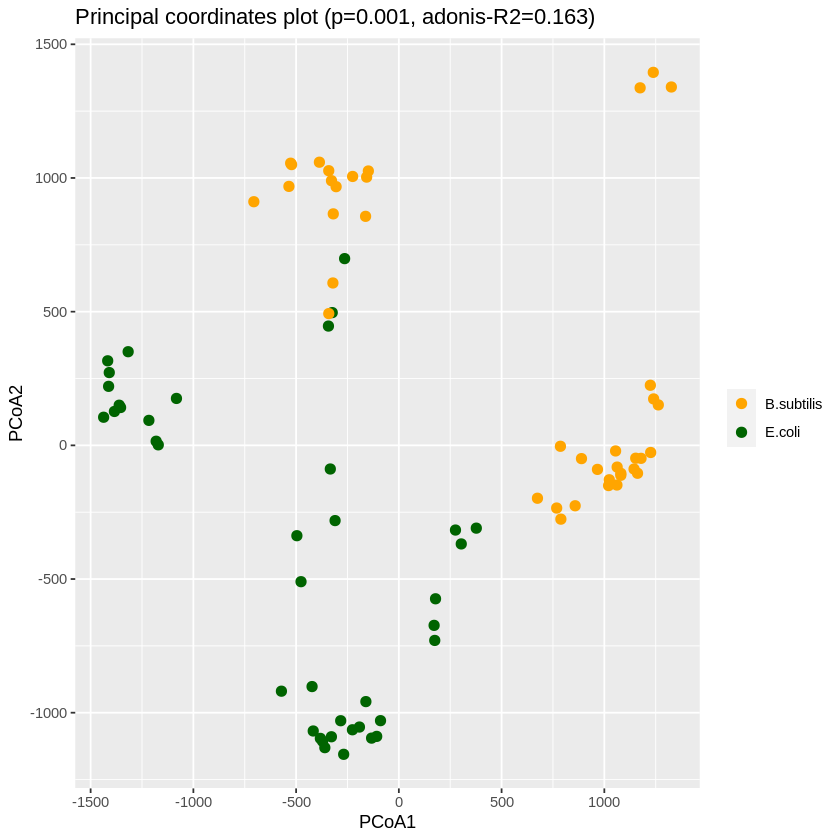

In [55]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_species", catcols = "ATTRIBUTE_species", mdtype = 'categorical', 
                      cols = c('orange','darkgreen'),
                      title = 'Principal coordinates plot')

- Is there a significant difference between samples with treatment and without? How much of the variation in our data can be explained by sample type?

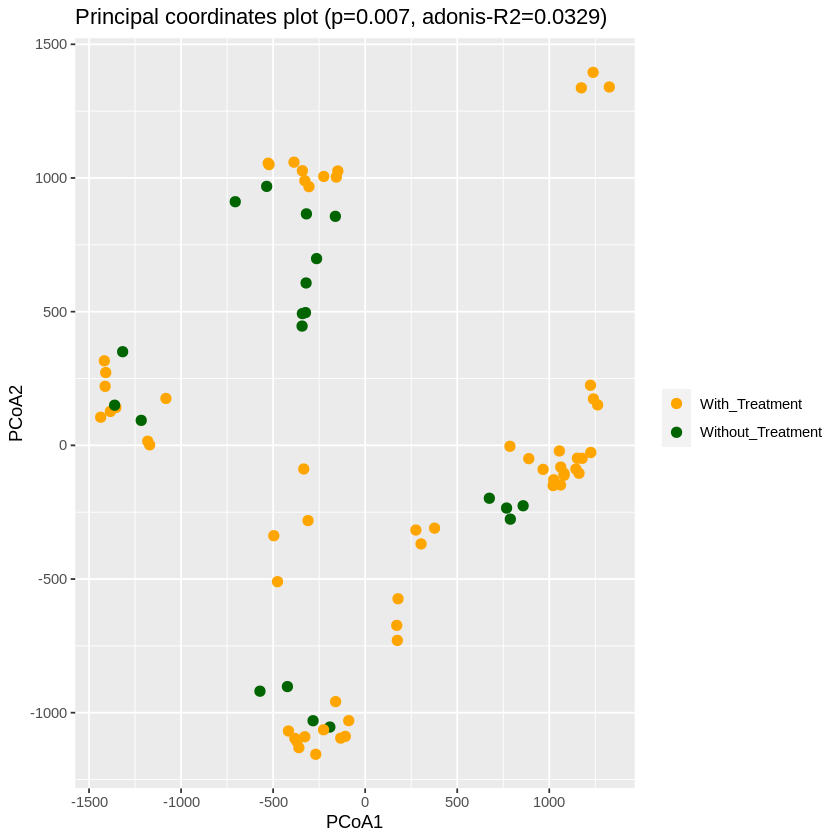

In [62]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_SampleType", catcols = "ATTRIBUTE_SampleType", mdtype = 'categorical', 
                      cols = c('orange','darkgreen'),
                      title = 'Principal coordinates plot')

There is a significant difference in the metabolomic profiles of samples and controls (PERMANOVA, P < 0.05, Adonis R2 = 0.0329). 3.29% of the variation in our data can be explained by sample type.

- Is there a significant difference between different timepoints? How much of the variation in our data can be explained by the timepoint the sample was collected?

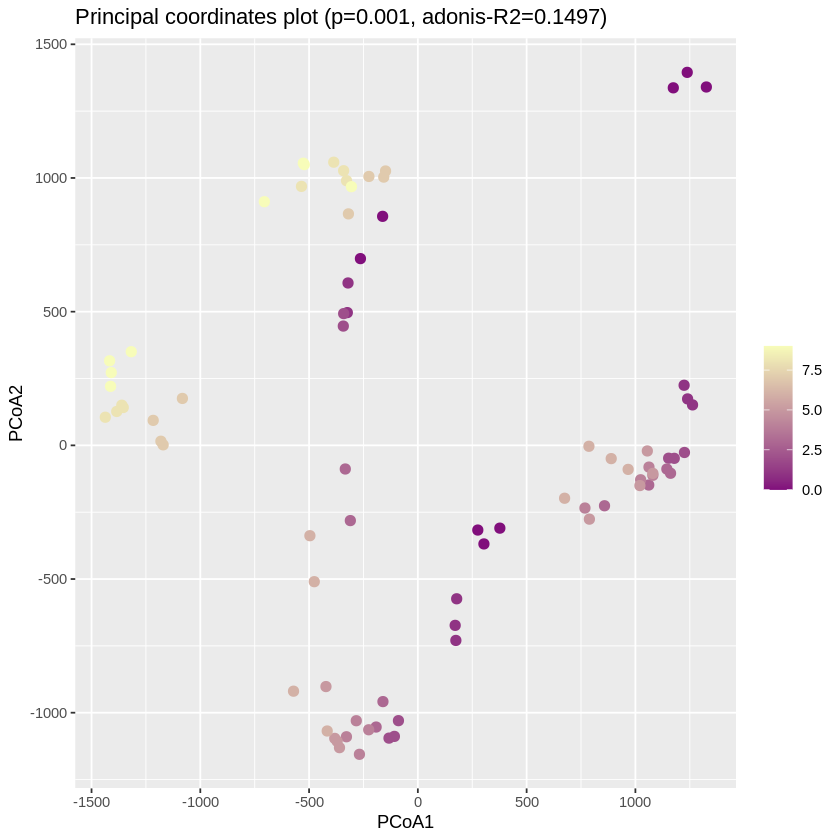

In [63]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_timepoint", catcols = "ATTRIBUTE_timepoint", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

- Is there a significant difference between different timepoints (in hours)? How much of the variation in our data can be explained by the timepoint the sample was collected?

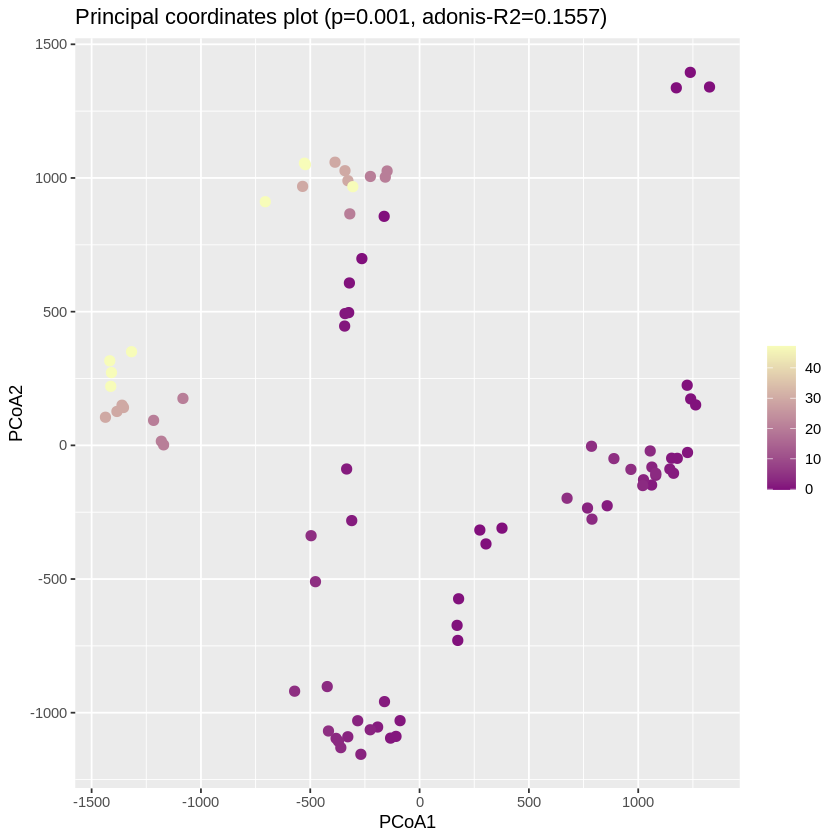

In [64]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_hours", catcols = "ATTRIBUTE_hours", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

- Is there a significant difference between different timepoints (in minutes)? How much of the variation in our data can be explained by the timepoint the sample was collected?

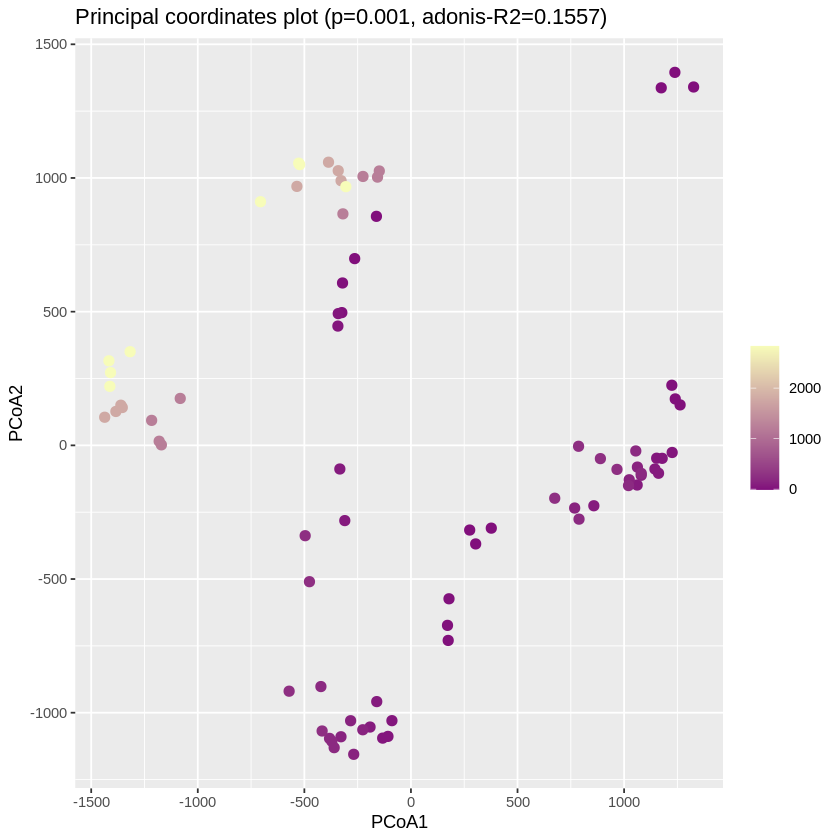

In [65]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_mins", catcols = "ATTRIBUTE_mins", mdtype = 'continuous', 
                      title = 'Principal coordinates plot')

There is a significant difference in the metabolomic profiles of samples collected at different timepoints (PERMANOVA, P < 0.05, Adonis R2 ≈ 0.15). ≈ 15% of the variation in our data can be explained by timepoint.

- Is there a significant difference between replicates? How much of the variation in our data can be explained by different replicates?

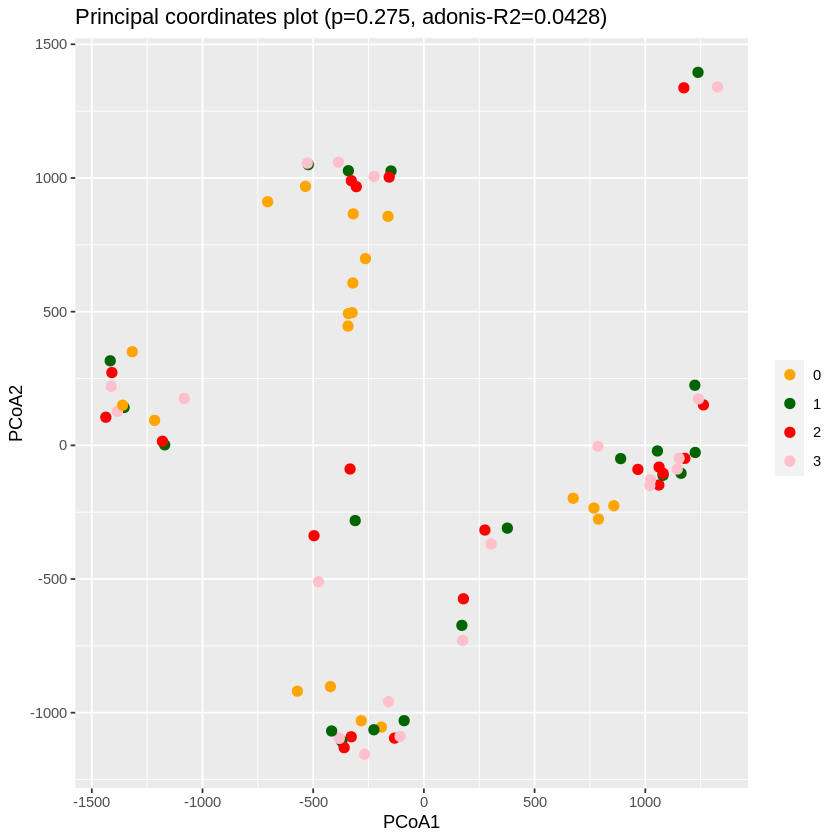

In [68]:
plotPCoA(ft, md, distmetric = "canberra", catper = "ATTRIBUTE_replicates", catcols = "ATTRIBUTE_replicates", mdtype = 'categorical', 
                      cols = c('orange','darkgreen','red','pink'),
                      title = 'Principal coordinates plot')

There is no difference between replicates.

In [69]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.6   vegan_2.6-2     lattice_0.20-45 permute_0.9-7  

loaded via a namespace (and not attached):
 [1] pillar_1.7.0     compiler_4.2.0   base64enc_0.1-3  tools_4.2.0     
 [5] digest_0.6.29    uuid_1.1-0       tibble_3.1.7     jsonlite_1.8.0  
 [9] evaluat